# Dungeons and Dragons Character Backstory Machine Learning Model

## Goals
My hopes for this exploration and technical modeling project is to create a product that takes in user output (Character Name, Character Species, and Character Class), and returns to the user a generated backstory. 

## How to accomplish this?
I am utilizing both the database created by [@janelleshane](https://github.com/janelleshane/DnD_bios) and ChatGPT4 to generate brief backstories. I also got a few backstories from some friends. I combined all of these into one dataset and worked on cleaning and preprocessing the data. My focus was to clean up the backstories and remove any stopwords and lemmentize words. This was to prepare the data for a seq2seq model I would train. 

## User interaction and the product
Users would provide the input. The product takes the input and predicts which type of backstory was relavant to the user. A random backstory would be pull from all related backstory clusters and then fed to the seq2seq model. The user receives back a generated paragraph of text. 

## First Steps
Read in the data and begin the cleaning process. I removed any rows that did not contain backstories, as they were useless to me. 

## Predictive Models
Next I used the character species and class to create clusters for the backstories. This would be used to help feed a backstory to the seq2seq model.

## Generate Text
The trickiest and hardest part of this project is returning to the user a comprehendable paragraph of text to be used for a backstory.

___

## Desired ouput vs. MVP
Due to the difficulty of this task and the time constaint imposed by the project, I did have to alter my expectations for the product released. It doesn't seem feasible, withouth using a very high powered, well trained NLP model, like GPT4, to produce the results I was looking for. Therefore, the new product will provide the user with some ideas or a word bank to use in crafting a backstory for their character. 

____

## We are going to try and limit the character classes/species
This test will see if we can create even better clusters with better content in them.
___

## Begin with the EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import pickle

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
char_df = pd.read_csv('data/dd_bios.csv', encoding='ISO-8859-1')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 5 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Timestamp                                       2429 non-null   object
 1   Character's name                                2429 non-null   object
 2   Character's race (human, elf, dwarf, etc)       2429 non-null   object
 3   Character's class (rogue, wizard, cleric, etc)  2429 non-null   object
 4   Character's backstory                           2322 non-null   object
dtypes: object(5)
memory usage: 95.0+ KB


In [5]:
# Assuming your DataFrame is called df
char_df = char_df.rename(columns={
    'Timestamp': 'timestamp',
    "Character's name": 'character_name',
    "Character's race (human, elf, dwarf, etc)": 'character_species',
    "Character's class (rogue, wizard, cleric, etc)": 'character_class',
    "Character's backstory": 'character_backstory'
})

In [6]:
char_df = char_df.drop(columns=['timestamp'])


In [7]:
char_df.head()

,character_name,character_species,character_class,character_backstory
0,Erryt,Aarakocra,Ranger,"Erryt, a 7 year-old Aarakocra with golden plum..."
1,Katyusha,Aarakocra,Cleric,Real name !k_usa\r\rLives in fantasy Soviet U...
2,Surkiikri,Aarakocra,Monk,Surkiikri was firstborn of the ruling family o...
3,Azriel,Aasamar,Paladin,He was raised the isles in a family of nobles ...
4,Mei Qiao,Aasimar,Paladin,NaN


In [8]:
char_df = char_df.dropna()

In [9]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2322 entries, 0 to 2428
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       2322 non-null   object
 1   character_species    2322 non-null   object
 2   character_class      2322 non-null   object
 3   character_backstory  2322 non-null   object
dtypes: object(4)
memory usage: 90.7+ KB


In [10]:
char_df.character_species.unique()

array(['Aarakocra', 'Aasamar', 'Aasimar', 'aasimar', 'Aasimar ', 'Alien',
       'Android', 'Anthropomorphic Cockroach', 'Aquatic Half-Elf',
       'Beeforged', 'Birali (homebrew, sort of like a cat-folk)',
       'Birali turned back to Human', 'Birdfolk', 'Blue Dragonborn',
       'BugBear', 'Cambion', 'Catfolk', 'Catgirl', 'Celestial',
       'Changeling', 'Copper Dragonborn', 'Dark Elf', 'dark elf',
       'Dark elf ', 'Dark Elf/Human', 'Deep Gnome', 'Demon', 'Dragonborn',
       'Dragonborn ', 'Drow', 'drow', 'Drow Elf', 'Drow elf ', 'Dwarf',
       'dwarf', 'Earth Genasi', 'Eladrin', 'Eladrin ', 'Elan', 'Elf',
       'elf', 'Elf ', 'Elf (Drow)', 'Elf (Wood)', 'Fey Corgi', 'Feyblood',
       'Fire genasi', 'Forest gnome', 'Forest Gnome', 'genasi', 'Genasi',
       'Ghostwise Halfling', 'Ghoul Medusa', 'Githyanki', 'Gnoll',
       'Gnome', 'gnome', 'goblin', 'Goblin', 'Goliath', 'goliath',
       'Grey Elf', 'Hafling', 'Half Cat folk/ Half Elf', 'Half drow',
       "Half dwarf, half

In [11]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()
char_df['character_name'] = char_df['character_name'].str.lower()
char_df['character_backstory'] = char_df['character_backstory'].str.lower()



# Verify the change
char_df['character_species'].value_counts()

character_species
human            685
half-elf         146
elf              125
tiefling         118
dwarf            117
                ... 
small cat          1
half left elf      1
black pudding      1
half-vampire       1
frogfolk           1
Name: count, Length: 333, dtype: int64

In [12]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

In [13]:
# We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is. 

char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')


In [14]:
# Your list of species
species = char_df.character_species.unique()

# Allowed species names
allowed_species = [
    'Aasimar', 'Dragonborn', 'Dwarf', 'Elf', 'Gnome',
    'Goliath', 'Halfling', 'Human', 'Orc', 'Tiefling'
]

# Define a function to clean up the species names and keep multiple valid species
def clean_species(species_string):
    # Make the species string lowercase for comparison
    species_string_lower = species_string.lower()

    # List to collect valid species found in the string
    found_species = []

    # Check if any allowed species appears in the string
    for allowed_speci in allowed_species:
        # Convert the allowed species to lowercase for comparison
        if allowed_speci.lower() in species_string_lower:
            found_species.append(allowed_speci)  # Add the valid species to the list

    # If any valid species were found, return them joined by slashes
    if found_species:
        return '/'.join(found_species)
    return None  # If no valid species is found, return None

In [15]:
# Apply the cleaning function to the 'character_class' column
char_df['cleaned_species'] = char_df['character_species'].apply(clean_species)

In [16]:
char_df['cleaned_species'].value_counts(dropna=False)

cleaned_species
Human             709
Elf               455
None              428
Halfling          128
Dwarf             127
Tiefling          125
Orc               121
Gnome              93
Dragonborn         77
Aasimar            31
Goliath            20
Elf/Human           3
Human/Orc           1
Elf/Orc             1
Gnome/Orc           1
Aasimar/Human       1
Human/Tiefling      1
Name: count, dtype: int64

In [17]:
char_df.character_class.unique()

array(['ranger', 'cleric', 'monk', 'paladin', 'cleric (tempest)',
       'wizard', 'fighter', 'sorcerer', 'weird musician bard',
       'bloodrager', 'gunslinger', 'storm sorcerer', 'bard', 'rogue',
       'rogue/paladin', 'druid', 'scout', 'goddess', 'assassin',
       'warlock', 'thief', 'cleric/druid', 'assasin',
       'wizard (necromancer)', 'dragon rider', 'barbarian',
       'monk, warlock', 'cleric ', 'rogue ', 'magus', 'rouge',
       'ardent (psionic fighter)', 'bard/necromancy wizard', 'sorcerer ',
       'warrior', 'sorceror', 'dwarf paragon', 'ninja', 'artificer',
       'fighter/cleric', 'stone sorcerer', 'rogue / sedimentologist',
       'psion', 'cleric/barbarian', 'cleric of knowledge', 'summoner',
       'wizard ', 'vengeance paladin', 'wizard warlord hybrid ',
       'stalker', 'archivist', 'bard ', 'cavalier', 'mystic',
       'rogue / arbiter (homebrew)', 'paladin-fighter', 'warmage',
       'beastmaster', 'enchanter ', 'alchemist ', 'fighter/sorceror',
       'fig

In [18]:
# Your list of classes
classes = char_df.character_class.unique()

# Allowed class names
allowed_classes = [
    'Barbarian', 'Bard', 'Cleric', 'Druid', 'Fighter', 'Monk', 
    'Paladin', 'Ranger', 'Rogue', 'Sorceror', 'Warlock', 'Warrior', 
    'Wizard'
]

# Define a function to clean up the class names and keep multiple valid classes
def clean_class(class_string):
    # Make the class string lowercase for comparison
    class_string_lower = class_string.lower()

    # List to collect valid classes found in the string
    found_classes = []

    # Check if any allowed class appears in the string
    for allowed_class in allowed_classes:
        # Convert the allowed class to lowercase for comparison
        if allowed_class.lower() in class_string_lower:
            found_classes.append(allowed_class)  # Add the valid class to the list

    # If any valid classes were found, return them joined by slashes
    if found_classes:
        return '/'.join(found_classes)
    return None  # If no valid class is found, return None


In [19]:
# Apply the cleaning function to the 'character_class' column
char_df['cleaned_class'] = char_df['character_class'].apply(clean_class)

In [20]:
char_df['cleaned_class'].value_counts(dropna=False)

cleaned_class
None                            517
Rogue                           240
Fighter                         202
Wizard                          193
Bard                            188
Cleric                          187
Paladin                         134
Warlock                         131
Ranger                          120
Barbarian                       103
Druid                           100
Monk                             95
Warrior                          17
Sorceror                         14
Fighter/Rogue                     6
Rogue/Wizard                      5
Cleric/Rogue                      4
Bard/Rogue                        4
Fighter/Wizard                    4
Paladin/Warlock                   3
Cleric/Fighter                    3
Ranger/Rogue                      3
Cleric/Monk                       3
Bard/Warlock                      3
Paladin/Wizard                    2
Bard/Paladin                      2
Monk/Rogue                        2
Fighter/Warloc

In [21]:
# Count rows where both 'cleaned_species' and 'cleaned_class' are None
none_count = char_df[(char_df['cleaned_species'].isna()) & (char_df['cleaned_class'].isna())].shape[0]
none_count

150

In [22]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2322 entries, 0 to 2428
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       2322 non-null   object
 1   character_species    2322 non-null   object
 2   character_class      2322 non-null   object
 3   character_backstory  2322 non-null   object
 4   cleaned_species      1894 non-null   object
 5   cleaned_class        1805 non-null   object
dtypes: object(6)
memory usage: 127.0+ KB


In [23]:
# Drop rows where either 'cleaned_class' or 'cleaned_species' is None
char_df = char_df.dropna(subset=['cleaned_class', 'cleaned_species'])

In [24]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1527 entries, 3 to 2428
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       1527 non-null   object
 1   character_species    1527 non-null   object
 2   character_class      1527 non-null   object
 3   character_backstory  1527 non-null   object
 4   cleaned_species      1527 non-null   object
 5   cleaned_class        1527 non-null   object
dtypes: object(6)
memory usage: 83.5+ KB


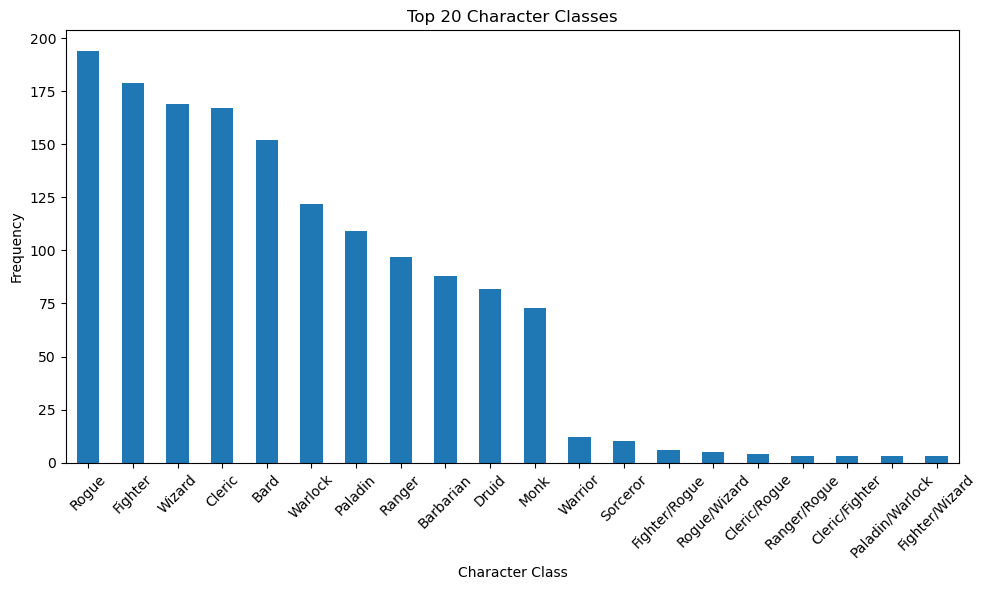

In [25]:
top_20_classes = char_df.cleaned_class.value_counts().head(20)

# Create the plot
plt.figure(figsize=(10,6))
top_20_classes.plot(kind='bar')
plt.title('Top 20 Character Classes')
plt.xlabel('Character Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

This is a solid representation of the 5ed classes available, and a good number of other types of classes that make up this dataset. 

Let's start cleaning up the rest of the text to get ready for tokenization

In [26]:
# !pip install nltk

In [27]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Make sure you have stopwords and lemmatizer from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
stop_words = set(stopwords.words('english'))

# Additional custom words to remove
custom_words = {"one", "would", "yet", "could", "though", "without", "like", "much"}
stop_words.update(custom_words)

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
# Function to remove tokens that consist only of underscores
def clean_text(text):
    # Use regex to replace sequences of underscores with a space if they consist entirely of underscores
    return re.sub(r'\b_+\b', ' ', text)

In [29]:
# Preprocessing function: tokenization, lemmatization, and stopword removal
def preprocess_backstory(text):

    cleaned_text = clean_text(text)

    tokens = tokenizer.tokenize(cleaned_text.lower())  # Lowercase and tokenize
    
    # Remove stopwords first
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the remaining tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Remove custom words and numbers
    final_tokens = [word for word in lemmatized_tokens if not re.search(r'\d', word) and word.isalpha()]
    
    return ' '.join(final_tokens)  # Join tokens back into a string


In [30]:
def generative_backstory(text, max_len=100):
    """
    Function to fit a tokenizer on backstory text with stopwords included,
    and return the tokenized and padded sequence ready for text generation.

    Parameters:
    - text (list or string): The input text or list of backstory texts.
    - max_len (int): Maximum length for padding the sequence (default is 100).

    Returns:
    - tokenizer: The fitted tokenizer.
    - padded_sequences: Tokenized and padded sequences.
    """
    # Ensure input is a list (for multiple backstories) or convert to a list if it's a single string
    if isinstance(text, str):
        text = [text]

    # Tokenizer fitting on text WITH stopwords
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(text)  # Fit tokenizer on the raw texts with stopwords

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(text)

    # Pad sequences to ensure consistent input length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    return tokenizer, padded_sequences

In [31]:
# Apply preprocessing to the character_backstory column
char_df['cleaned_backstory'] = char_df['character_backstory'].apply(preprocess_backstory)

In [32]:
char_df['generative_backstory'] = char_df['character_backstory'].apply(lambda x: generative_backstory(x)[1])

In [33]:
char_df['cleaned_backstory'][10]

'born pure blooded aasimar family lived father two younger sister father hippy constantly preached word pan sister always charity work whenever zea however became opposite went church family complaint eventually grew tired praise someone even know care aged moved live struggled lot money debt hesitantly began praise goddess lyvalia soon became someone silver tongue able swindle praise wealth near common folk happy back square worshipping someone care researched found people called separatist go god follow path still getting benefit old god staying good grace aged stroll around miserable town praising powerful goddess show holy flame beauty nothing lose occasional praise lyvalia since still need spread word get benefit installs utter terror stray'

In [34]:
char_df['character_backstory'][10]

'she was born to a pure blooded aasimar family, and lived with her father and two younger sisters. her father was very much a hippy, he constantly preached the word of pan, and her sisters always did charity work whenever they could. zea however became very much the opposite. while she went to church with her family without complaint, she eventually grew tired of having to praise someone she didn\'t even know or care about.\r\rthat was when, at aged 36, she moved out to live on her own. she struggled a lot with money and debts so she, very hesitantly, began to praise the goddess lyvalia. very soon she became someone with a silver tongue, and was able to swindle praise and wealth out of near any common folk. but she wasn\'t happy, she was back at square one, worshipping someone she doesn\'t care for. so she researched, and found people called "separatists", who can go against their gods and follow their own path, while still getting the benefits from their old god and staying in good gr

In [35]:
char_df['generative_backstory'][10]

array([[  6,  94,  23,  95,  96,  97,  13,   2,  98,  22,  99,  27,   2,
        100,   4, 101, 102, 103, 104,  30, 105, 106, 107,  14, 108,   4,
        109,  14,  26, 110,  21,  31, 111,   9,  32,  33,  14, 112, 113,
          4, 114, 115, 116, 117, 118,  24, 119,   2, 120, 121, 122, 123,
        124, 125, 126,   7, 127,  28,   2, 128, 129,   5, 130, 131,   4,
        132, 133,   2, 134, 135,   3, 136,   8,   9, 137,  11,   3,  29,
        138,   2,  31, 139,   3, 140,   5,  19,   3, 141,   5,  32,   4,
        142, 143, 144,   3, 145,  30, 146,  33,   5]])

In [36]:
from collections import Counter

# Flatten all preprocessed backstories into one large list of words
all_words = ' '.join(char_df['cleaned_backstory']).split()

# Calculate word frequencies
word_freq = Counter(all_words)

In [37]:
sorted(word_freq)

['aarackoan',
 'aaron',
 'aasimar',
 'aback',
 'abaewen',
 'abaewin',
 'abaewinõs',
 'abaivoi',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abato',
 'abbot',
 'abby',
 'abbys',
 'abdication',
 'abducted',
 'abducting',
 'abernathy',
 'aberration',
 'aberrock',
 'abhorred',
 'abhorrent',
 'abide',
 'abiding',
 'ability',
 'abject',
 'abjuration',
 'abjurer',
 'ablaze',
 'able',
 'abnormal',
 'aboard',
 'abode',
 'aboleth',
 'aboleths',
 'abomination',
 'abortive',
 'abound',
 'abounded',
 'abounding',
 'abrasive',
 'abrasiveness',
 'abraxos',
 'abridged',
 'abroad',
 'abrogail',
 'abrupt',
 'abruptly',
 'absalom',
 'absconded',
 'absence',
 'absent',
 'absentee',
 'absentism',
 'absentmindedly',
 'absolute',
 'absolutely',
 'absolution',
 'absolve',
 'absolved',
 'absorb',
 'absorbed',
 'absorbing',
 'abstract',
 'abstracted',
 'absurdity',
 'abundance',
 'abuse',
 'abused',
 'abuser',
 'abusive',
 'abuzz',
 'abyss',
 'abyssal',
 'academa',
 'academia',
 'academic',
 'aca

The cleaned text looks better now after a few updated iterations of cleaning.

In [38]:
# Vectorize the cleaned backstories using TF-IDF
vectorizer = TfidfVectorizer()
vectored_backstory = vectorizer.fit_transform(char_df['cleaned_backstory'])

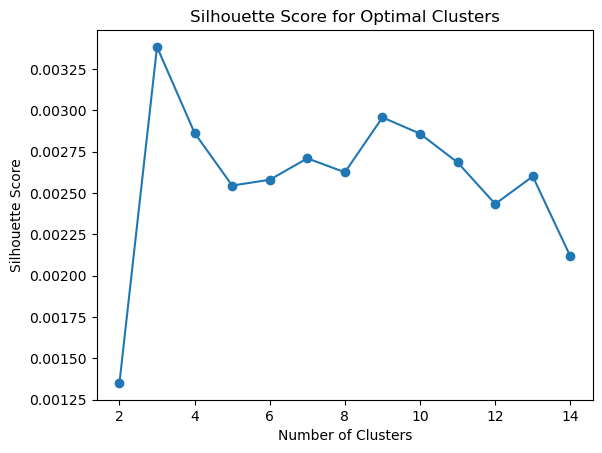

In [39]:
# Evaluate the Silhouette Score for different numbers of clusters
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vectored_backstory)
    silhouette_scores.append(silhouette_score(vectored_backstory, labels))

# Plot the Silhouette Score
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [40]:
silhouette_scores

[0.0013505378277839477,
 0.00338241013787113,
 0.0028621223542513625,
 0.0025441954967378067,
 0.002579110899574176,
 0.0027086632770108644,
 0.002624286819033145,
 0.0029562876579630444,
 0.002857630956384593,
 0.0026835936131775146,
 0.0024327281997958044,
 0.002599434996673819,
 0.002115986169140868]

In [41]:
max_value = max(silhouette_scores)
index_of_max = silhouette_scores.index(max_value)
index_of_max

1

Choose the number of clusters that yields the highest silhouette score.

In [42]:
# Use K-Means clustering to find themes
num_clusters = index_of_max+2  # Based on the silohuette score above. 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(vectored_backstory)

# Add the cluster labels as the theme category
char_df['backstory_cluster'] = kmeans.fit_predict(vectored_backstory)



In [85]:
# View the DataFrame with the new cluster labels
print(char_df[['character_name', 'cleaned_species', 'cleaned_class', 'backstory_cluster']])

           character_name cleaned_species    cleaned_class  backstory_cluster
3                  azriel         Aasimar          Paladin                  2
5                 azophyr         Aasimar          Paladin                  0
6      mayanna blackthorn         Aasimar          Paladin                  0
7         ambriel falafel         Aasimar          Paladin                  0
8                   aldea         Aasimar           Cleric                  2
...                   ...             ...              ...                ...
2423                  tal           Gnome            Druid                  1
2424    desdemona veritas           Human            Rogue                  1
2425  dreyard bloodfallen           Human           Wizard                  0
2426       varan al-vacra           Human  Paladin/Warlock                  0
2428                 ront             Orc           Ranger                  1

[1527 rows x 4 columns]


In [86]:
char_df

,character_name,character_species,character_class,character_backstory,cleaned_species,cleaned_class,cleaned_backstory,generative_backstory,backstory_cluster,encoded_name,encoded_species,encoded_class
3,azriel,aasimar,paladin,he was raised the isles in a family of nobles ...,Aasimar,Paladin,raised isle family noble close tie god angelic...,"[[6, 8, 9, 2, 5, 10, 11, 12, 7, 13, 14, 15, 16...",2,153,1,82
5,azophyr,aasimar,paladin,hi... i'm azophyr. i'm a fallen aasimar devoti...,Aasimar,Paladin,hi azophyr fallen aasimar devotion paladin enc...,"[[12, 4, 5, 4, 6, 13, 14, 15, 16, 17, 18, 19, ...",0,152,1,82
6,mayanna blackthorn,aasimar,paladin,was found on the steps of a temple to heironeo...,Aasimar,Paladin,found step temple heironeous young child raise...,"[[7, 15, 8, 2, 16, 4, 3, 9, 5, 10, 11, 3, 17, ...",0,887,1,82
7,ambriel falafel,aasimar,paladin,"ambriel, the haunted one, is on a quest to van...",Aasimar,Paladin,ambriel haunted quest vanquish evil upstanding...,"[[18, 19, 8, 9, 20, 21, 10, 22, 5, 23, 11, 24,...",0,73,1,82
8,aldea,aasimar,cleric (tempest),aldea was born in a kingdom where magic was ev...,Aasimar,Cleric,aldea born kingdom magic everywhere wizard rul...,"[[24, 6, 2, 3, 12, 25, 26, 27, 28, 29, 30, 5, ...",2,41,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...
2423,tal,gnome,druid,he was born in the intersection between the de...,Gnome,Druid,born intersection desert plane kemoninko gnome...,"[[3, 5, 14, 6, 2, 15, 16, 2, 7, 8, 9, 17, 6, 2...",1,1283,27,33
2424,desdemona veritas,human,rogue,desdemona grew up in an artistic environment f...,Human,Rogue,desdemona grew artistic environment full perfo...,"[[77, 78, 8, 27, 5, 79, 16, 2, 80, 18, 6, 29, ...",1,363,56,106
2425,dreyard bloodfallen,human,wizard,orphan,Human,Wizard,orphan,"[[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,390,56,154
2426,varan al-vacra,human,paladin/warlock,varan is a prince of the ancient line of vacra...,Human,Paladin/Warlock,varan prince ancient line vacra count many fam...,"[[3, 4, 5, 6, 2, 7, 8, 9, 2, 10, 11, 12, 13, 1...",0,1414,56,89


In [45]:
from collections import Counter

# Function to get word frequency for a cluster
def get_word_frequency(cluster_num):
    # Filter rows belonging to the specified cluster
    cluster_text = char_df[char_df['backstory_cluster'] == cluster_num]['cleaned_backstory']
    
    # Join all backstories in the cluster into a single string
    all_words = ' '.join(cluster_text).split()
    
    # Use Counter to get word frequencies
    word_freq = Counter(all_words)
    
    # Get the top 10 most common words in the cluster
    return word_freq.most_common(10)

# Loop over each cluster and get word frequencies
n_clusters = char_df['backstory_cluster'].nunique()  # Find the number of unique clusters

for cluster_num in range(n_clusters):
    print(f"\nCluster {cluster_num} - Top Words:")
    top_words = get_word_frequency(cluster_num)
    for word, freq in top_words:
        print(f"{word}: {freq}")


Cluster 0 - Top Words:
world: 143
god: 131
life: 110
raised: 108
child: 96
people: 85
left: 82
family: 80
way: 77
good: 72

Cluster 1 - Top Words:
time: 869
year: 793
family: 779
life: 670
father: 615
mother: 597
day: 583
found: 550
way: 549
back: 497

Cluster 2 - Top Words:
noble: 74
family: 61
son: 14
life: 13
city: 13
name: 12
forced: 12
day: 11
left: 11
found: 11


______

To begin predicting on these clusters, we will need to turn the features into numerical data

_______

In [46]:
# Step 1: Encode categorical features (name, species, class) into numeric form
le_name = LabelEncoder()
le_species = LabelEncoder()
le_class = LabelEncoder()

char_df['encoded_name'] = le_name.fit_transform(char_df['character_name'])
char_df['encoded_species'] = le_species.fit_transform(char_df['character_species'])
char_df['encoded_class'] = le_class.fit_transform(char_df['character_class'])

In [47]:
# Features and target
X = char_df[['encoded_species', 'encoded_class']]
y = char_df['backstory_cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Trying to balance my classes with some SMOTE

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

____

## Basic Machine Learning Shotgun Approach


____

In [49]:
# Define the models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Naive Bayes': MultinomialNB(),  # Naive Bayes often works well with categorical data
    'XGBoost': XGBClassifier()
}

In [50]:
# Go through all models to see best out of the box
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Use MinMaxScaler for MultinomialNB
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),  # Use MinMaxScaler for Naive Bayes to avoid negative values
            ('classifier', model)
        ])
    else:
        # Use StandardScaler for the other models
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Use StandardScaler for other models
            ('classifier', model)
        ])
    
    # Train the model
    pipeline.fit(X_resampled, y_resampled)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    
    # Classification report
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=0))

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       156
           1       0.46      0.43      0.44       136
           2       0.10      0.29      0.15        14

    accuracy                           0.43       306
   macro avg       0.36      0.39      0.36       306
weighted avg       0.47      0.43      0.45       306

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       156
           1       0.25      0.01      0.01       136
           2       0.06      0.57      0.10        14

    accuracy                           0.30       306
   macro avg       0.27      0.37      0.21       306
weighted avg       0.38      0.30      0.28       306

Results for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.55      0.34      0.42       156
           1       0.44      0

____

Random Forest turned out the best initial accuracy, a very low 42%. Let's try and improve on that.\
XGBoost gave us 44%

UPDATE:\
After doing some more prepocessing of the text to remove some more dirty data and stopwords we are getting better accuracy out of the gate.\
Random Forest is giving 74%\
XGBoost is giving 78%

_____

In [51]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# rf = RandomForestClassifier(class_weight='balanced', random_state=42)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(classification_report(y_test, y_pred))

____

grid search made it worse!

____

In [52]:
# model = RandomForestClassifier(class_weight='balanced', random_state=42)
# scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
# print(f"Mean accuracy: {scores.mean()}")

Using the voting classifier, we can use mulitple models together. 

In [53]:
from sklearn.ensemble import VotingClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', LogisticRegression(solver='saga', max_iter=500, random_state=42))
])

model1 = RandomForestClassifier(class_weight='balanced', random_state=42)
# model2 = LogisticRegression(max_iter=500, random_state=42)
model3 = SVC(probability=True, class_weight='balanced', random_state=42)
model4 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('rf', model1), ('lr', pipeline), ('svc', model3), ('xgb', model4)],
    voting='soft')

ensemble_model.fit(X_resampled, y_resampled)
y_pred = ensemble_model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.53      0.47      0.50       156
           1       0.49      0.46      0.48       136
           2       0.10      0.29      0.15        14

    accuracy                           0.46       306
   macro avg       0.37      0.41      0.37       306
weighted avg       0.49      0.46      0.47       306



___

We are up to 45%, not really amazing at all.\ 
Added xgboost and got to 47%. There are a lot of zeroed out classes here. 

UPDATE:\
Again, we have better accuracy out of the gate. We are look at 78% with better f-scores overall than previously

____

Let's stick with XGBoost

In [54]:

# Define the pipeline with scaling and the XGBClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Fit the model
pipeline.fit(X_resampled, y_resampled)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.48      0.51       156
           1       0.51      0.46      0.48       136
           2       0.10      0.29      0.14        14

    accuracy                           0.46       306
   macro avg       0.38      0.41      0.38       306
weighted avg       0.50      0.46      0.48       306



In [55]:
from sklearn.utils.class_weight import compute_class_weight

# Get the class distribution
classes = np.unique(y_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)

# Create a dictionary of class weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update your XGBClassifier with class weights
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=class_weights_dict)

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'classifier__max_depth': [3, 4, 5, 6, 7],
#     'classifier__n_estimators': [100, 200, 300, 400, 500]
# }

# Best hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 500}
param_grid = {
    'classifier__learning_rate': [0.05],
    'classifier__max_depth': [7],
    'classifier__n_estimators': [500]
}

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', xgb_clf)
])

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_weighted', cv=10, verbose=1, n_jobs=-1, refit=True)


# Train the model
grid_search.fit(X_resampled, y_resampled)

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Get the best parameters from the grid search
print("Best hyperparameters:", grid_search.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.53      0.48      0.51       156
           1       0.50      0.46      0.48       136
           2       0.10      0.29      0.15        14

    accuracy                           0.46       306
   macro avg       0.38      0.41      0.38       306
weighted avg       0.50      0.46      0.48       306

Best hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 500}


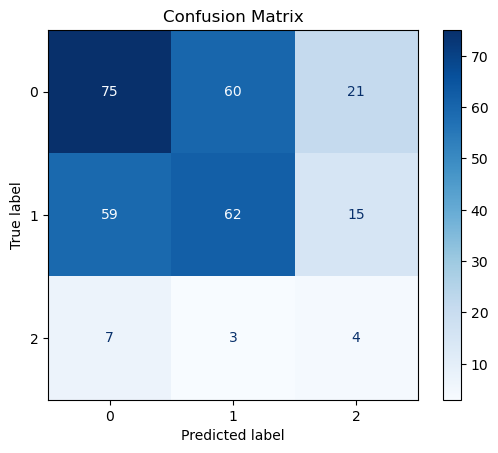

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

____ 

## Saving content section
uncomment when necessary

____

In [57]:
# import json

# # After grid search, extract the best XGBClassifier from the pipeline
# best_xgb_model = grid_search.best_estimator_.named_steps['classifier']

# # Save the XGBoost model to JSON
# best_xgb_model.save_model('xgb_model.json')

In [58]:
# # Save the model in binary format
# best_xgb_model.save_model('word_bank_app/xgb_model.model')

In [59]:
# import joblib

# # Save the trained model to a file
# joblib.dump(grid_search.best_estimator_, 'word_bank_app/trained_xgb_model.pkl')

In [60]:
# import pickle

# # Save the trained pipeline model using pickle
# with open('word_bank_app/trained_pipeline.pkl', 'wb') as model_file:
#     pickle.dump(grid_search.best_estimator_, model_file)

In [61]:
# # Replace 'your_dataframe' with the actual name of your dataframe
# char_df.to_csv('cleaned_df.csv', index=False)

____

## Testing functionality for product

____

In [62]:
input_species = 'lizard'
input_class = 'druid'  


species_encoder = dict(zip(char_df['character_species'].str.lower(), char_df['encoded_species']))
class_encoder = dict(zip(char_df['character_class'].str.lower(), char_df['encoded_class']))


encoded_species = species_encoder.get(input_species.lower(), -1)
encoded_class = class_encoder.get(input_class.lower(), -1)

# Check if any encoding failed
if -1 in [encoded_species, encoded_class]:
    print("Error: One of the input values is invalid.")
else:
    # Combine the encoded values into a feature array
    input_features = np.array([[encoded_species, encoded_class]])

    # Use the trained model to predict the cluster
    predicted_cluster = grid_search.best_estimator_.predict(input_features)

    # Output the predicted cluster
    print(f"The predicted cluster for the character is: {predicted_cluster[0]}")

Error: One of the input values is invalid.


________
## Neural Net Work
______

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

texts = char_df['cleaned_backstory'].tolist()

_____

In [64]:
# Tokenize and prepare data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Save the tokenizer to a file
with open('word_bank_app/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index) + 1

# Convert texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(texts)

# Define max_len (adjustable)
max_len = 100

# Generator function to yield batches of data
def data_generator(sequences, batch_size, max_len, vocab_size):
    num_samples = len(sequences)
    while True:
        for offset in range(0, num_samples, batch_size):
            # Create a batch of input sequences (X) and target sequences (y)
            X_batch = [seq[:-1] for seq in sequences[offset:offset + batch_size]]
            y_batch = [seq[1:] for seq in sequences[offset:offset + batch_size]]
            
            # Pad sequences to max_len
            X_batch = pad_sequences(X_batch, maxlen=max_len, padding='post')
            y_batch = pad_sequences(y_batch, maxlen=max_len, padding='post')
            
            # Convert to float32 to reduce memory usage
            X_batch = X_batch.astype('float32')
            y_batch = np.array([np.eye(vocab_size)[seq] for seq in y_batch], dtype='float32')
            
            yield [X_batch, X_batch], y_batch  # Yield inputs and targets as a tuple

# Model definition
embedding_dim = 64
latent_dim = 128 # reducing this from 256 since data set isn't super large. 

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.2) # adding dropouts to help with overfitting
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding) # get the hidden state and cell state
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len,))
decoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set batch size and number of steps per epoch
batch_size = 16
steps_per_epoch = len(sequences) // batch_size



In [65]:
print(tokenizer.word_index.get('and'))  # Should return a valid index

None


In [66]:
# Print out the first 20 words in the tokenizer's vocabulary
for word, index in list(tokenizer.word_index.items())[:20]:
    print(f"{word}: {index}")

<OOV>: 1
time: 2
family: 3
year: 4
life: 5
father: 6
mother: 7
day: 8
way: 9
found: 10
never: 11
world: 12
back: 13
child: 14
left: 15
took: 16
city: 17
town: 18
even: 19
home: 20


In [67]:
# # Train the model using the updated `fit` method
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [68]:
# # Save the model after training
# model.save('seq2seq_model.h5')

In [69]:
# # Save the model after training
# model.save('seq2seq_new_clean_model.h5')

In [70]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('word_bank_app/seq2seq_new_clean_model.h5')

In [71]:
# # Resume training from where it left off
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [72]:
# from tensorflow.keras.optimizers import Adam

# # Lower the learning rate to fine-tune
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# # Continue training
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [73]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 64)      1505216     ['input_6[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 64)      1505216     ['input_7[0][0]']                
                                                                                            

In [74]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Create a callback to save the model after each epoch
# checkpoint = ModelCheckpoint('seq2seq_checkpoint.h5', save_best_only=True, monitor='loss', mode='min')

# # Train the model with the checkpoint callback
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50, callbacks=[checkpoint])

In [75]:
# # Save the model after training
# model.save('seq2seq_02_model.h5')

In [76]:
# Step 1: Define inference models

# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Retrieve the correct embedding layer for the decoder ('embedding_6')
decoder_embedding_layer = model.get_layer('embedding_6')  # Use the correct decoder embedding layer name
decoder_inputs_inf = Input(shape=(1,))  # One word at a time
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_inf)

# Decoder LSTM (for inference, one word at a time)
decoder_lstm_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]

# Dense layer to generate the next word
decoder_outputs_inf = decoder_dense(decoder_lstm_inf)

# Define the decoder model for inference
decoder_model = Model([decoder_inputs_inf] + decoder_states_inputs, [decoder_outputs_inf] + decoder_states_inf)

In [77]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        multiple             1505216     ['input_5[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

In [78]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           1244352   
                                                                 
 lstm (LSTM)                 [(None, 128),             98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 1,343,168
Trainable params: 1,343,168
Non-trainable params: 0
_________________________________________________________________


In [79]:
# !pip install pydot

In [80]:
# Save the encoder model
encoder_model.save('word_bank_app/encoder_model.h5')

# Save the decoder model
decoder_model.save('word_bank_app/decoder_model.h5')

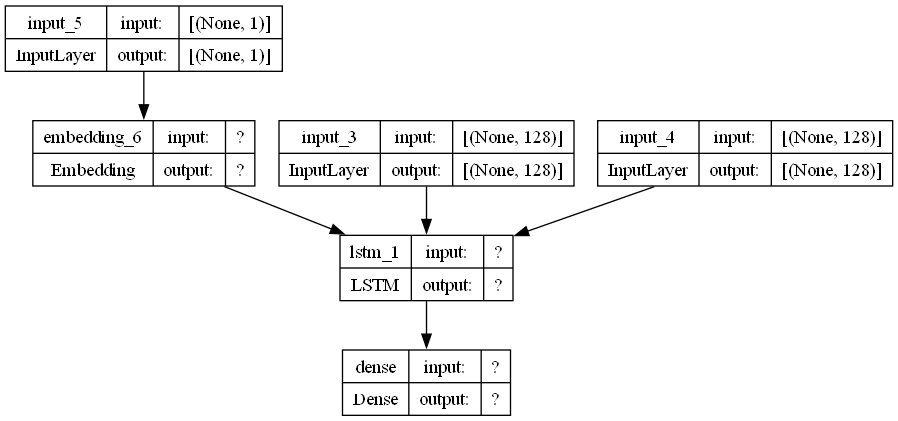

In [81]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

In [82]:
# Adding a temperature parameter

def sample_with_temperature(predictions, temperature=0.2):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-8) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    return np.random.choice(range(len(predictions)), p=predictions)

In [83]:
def generate_text(input_seq, tokenizer, max_len, temperature=0.2):
    # Encode the input sequence to get the initial state
    states_value = encoder_model.predict(input_seq)

    # # Prepare the target sequence (start with the "start" token or first word)
    # target_seq = np.zeros((1, 1))  # Decoder input starts with a single token
    # target_seq[0, 0] = tokenizer.word_index.get('start', 1)  # Use 'start' token or default token

    # Prepare the target sequence using the seed sequence (first four words)
    target_seq = input_seq[:, :1]  # Start with the first word of the input sequence

    # Initialize the output sequence
    stop_condition = False
    generated_text = []

     # If you want to preserve the first four words in the generated text
    # Add them directly to the generated_text list
    for word_id in input_seq[0]:
        if word_id != 0:  # Avoid padding tokens
            generated_text.append(tokenizer.index_word.get(word_id, ''))
    
    while not stop_condition:
        # Predict the next word using decoder model
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the next word using temperature-based sampling
        sampled_token_index = sample_with_temperature(output_tokens[0, -1, :], temperature)
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # Add the word to the generated text
        generated_text.append(sampled_word)

        # Stop if 'end' token is predicted or sequence is too long
        if sampled_word == 'end' or len(generated_text) >= max_len:
            stop_condition = True

        # Update the target sequence (shift the word) and update states
        target_seq = np.zeros((1, 1))  # Prepare for the next word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(generated_text)

In [87]:
sample_sentence = char_df['character_backstory'][60]

first_four_words = ' '.join(sample_sentence.split()[:4])

first_four_words

'left on the doorstep'

In [88]:
char_df['character_backstory'][60]

'left on the doorstep of a monastery   dedicated to bahomet when he was a month old. was taken in by a cleric named brother joseph, a half-elf who gave him the name ilith, with the sapphire becoming a nickname from his blue scales. ilith was not suited for priest work due to being a  dumbass (int of 8) but still wanted to serve the god who gave him a second chance, so he became a paladin. after completing his rites, his monastery was attacked by disciples of tiamat, who slew most of the priests, including brother joseph. he fled from the isle and found the city of liechport (homebrew) where our story begins. '

In [89]:
sample_sentence

'left on the doorstep of a monastery   dedicated to bahomet when he was a month old. was taken in by a cleric named brother joseph, a half-elf who gave him the name ilith, with the sapphire becoming a nickname from his blue scales. ilith was not suited for priest work due to being a  dumbass (int of 8) but still wanted to serve the god who gave him a second chance, so he became a paladin. after completing his rites, his monastery was attacked by disciples of tiamat, who slew most of the priests, including brother joseph. he fled from the isle and found the city of liechport (homebrew) where our story begins. '

In [90]:
# Test generation with a seed sequence
seed_text = first_four_words  # Use a starting text from your data
seed_sequence = tokenizer.texts_to_sequences([seed_text])
seed_sequence = pad_sequences(seed_sequence, maxlen=max_len, padding='post')

In [91]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

____

Can we add more nuance to the sentences with some filler words and punctuation?

____

In [92]:
import random

# List of filler words categorized by parts of speech
filler_words_by_pos = {
    'NN': ['the', 'a', 'some', 'this', 'that', 'any', 'one', 'each'],  # Articles and determiners for nouns
    'VB': ['is', 'was', 'has', 'will', 'might', 'can', 'could', 'would', 'should'],  # Auxiliary verbs
    'JJ': ['very', 'quite', 'rather', 'extremely', 'fairly', 'pretty', 'really', 'somewhat'],  # Intensifiers for adjectives
    'IN': ['with', 'by', 'on', 'from', 'under', 'over', 'through', 'in', 'around', 'at'],  # Prepositions
    'RB': ['probably', 'definitely', 'clearly', 'certainly', 'obviously', 'possibly', 'evidently'],  # Adverbs for verbs/adjectives
    'CC': ['and', 'or', 'but', 'so', 'yet'],  # Conjunctions
    'PRP': ['he', 'she', 'it', 'they', 'we', 'you', 'I'],  # Pronouns for general context
    'MD': ['will', 'would', 'can', 'could', 'might', 'must', 'should', 'shall'],  # Modal verbs
}

# Function to intelligently add filler words using POS tagging
def add_filler_words_smart(generated_text, filler_words_by_pos, insertion_prob=0.3):
    words = nltk.word_tokenize(generated_text)  # Tokenize the text
    pos_tags = nltk.pos_tag(words)  # Get POS tags for the generated text
    new_text = []
    
    for word, pos in pos_tags:
        new_text.append(word)
        
        # If the word's POS is in our filler_words_by_pos dictionary, insert a filler word
        if pos in filler_words_by_pos and random.random() < insertion_prob:
            filler_word = random.choice(filler_words_by_pos[pos])
            new_text.append(filler_word)
    
    return ' '.join(new_text)



In [93]:
# Function to generate structured sentences using POS tagging on enhanced text
def generate_structured_text(enhanced_text, max_sent_len=10):
    words = nltk.word_tokenize(enhanced_text)  # Tokenize the text into words
    pos_tags = nltk.pos_tag(words)  # Get POS tags for the words
    
    generated_sentences = []
    current_sentence = []

    # Iterate through the POS tagged words and structure sentences
    for word, pos in pos_tags:
        current_sentence.append(word)
        
        # Define basic sentence-ending logic based on POS
        # End the sentence if a noun, verb, or adjective has been seen and sentence is long enough
        if pos in ('NN', 'VB', 'JJ') and len(current_sentence) >= max_sent_len:
            generated_sentences.append(' '.join(current_sentence))
            current_sentence = []
    
    # Add any remaining words as the last sentence
    if current_sentence:
        generated_sentences.append(' '.join(current_sentence))

    # Join the sentences with punctuation
    punctuated_text = '. '.join(generated_sentences) + '.'
    
    return punctuated_text


In [94]:
# Example usage after generating text
generated_text = generate_text(seed_sequence, tokenizer, max_len)

# Generate the enhanced text by inserting filler words based on POS tags
enhanced_text = add_filler_words_smart(generated_text, filler_words_by_pos)

punctuated_text = generate_structured_text(enhanced_text)

print("Generated text with smart fillers:", punctuated_text)

1/1 [==============================] - 0s 19ms/step
Generated text with smart fillers: left < fairly OOV > < OOV > doorstep sickening dismay. naanaj classmate bestowed tharrakir dull powerfully apprenticed stumbling moriartyõs this reopened loath. pretty interference fleece genteel a gabriel physically wilbur thorny scrutinized abounded incident. fandolin indefinite pretty ayas wet tenacious rather polished furion overflow by northwest repercussion. dabbled plotted gatekeeper straying sensitivity each herding troop congratulated chiefdom. hastily certainly dealt certainly feasted rather skirmish pretty eilistraee one dregful. archbishop any bless singed tielfing fence some combatant pistoph spore. nixi prominently evidently pore certainly flamboyantly litter extracting forcibly ops grappler. crowned sized reluctant gooder sparing perceived pretty hadrian rather athame. unconsciou insulted prone scruple dared hereó eirik dawdled raft this mischief. this truth one wreak some spokeñreveal

We are getting better text, but it is still a bit odd. One example:

Generated text with smart fillers: queen rather never pretending noise rate started skin a found. wear wave some punched poor klaetus stopped figure best enough find something. sure quite despite shown god punched ashamed reputation some prison. some non often totally sense debt actively going place determine. curse the needed view world realise regarding wisdom particularly lessened desperately currently hook. trust stood man remain remains mad rather earning name a person. money despite guess began get song introduced natured first intention. suffering possible add seat slew took recognize face skill fault. around future very almost seemed work embracing time the family. even friend rather since by day a mother dad childhood. name a feel redemption some way adventurer a also goal.

____

## Transformer Section (Turned off for now)
____

In [126]:
# !pip install transformers


In [127]:
# from transformers import TFAutoModelForMaskedLM, RobertaTokenizer, AutoTokenizer, TFRobertaForMaskedLM, TFAutoModelForCausalLM

In [128]:
# # Load BERT for masked language modeling
# bert_model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
# bert_model = TFAutoModelForMaskedLM.from_pretrained(bert_model_name)

# def refine_with_bert(text):
#     # Replace specific words with [MASK] token for BERT to predict
#     masked_text = text.replace("some", "[MASK]")
#     inputs = tokenizer.encode(masked_text, return_tensors="tf")
#     outputs = bert_model(inputs)
#     predictions = outputs.logits

#     # Get the predicted word for [MASK]
#     mask_token_index = tf.where(inputs == tokenizer.mask_token_id)[0, 1]
#     predicted_token_id = tf.argmax(predictions[0, mask_token_index], axis=-1)
#     predicted_token = tokenizer.decode(predicted_token_id)
#     print(f'token:{predictions[0, mask_token_index]}')
#     print(f'predict:{predicted_token_id}')
#     # print(predicted_token)

#     refined_text = masked_text.replace("[MASK]", predicted_token)
#     return refined_text

# # Example usage
# pre_generated_text = punctuatated_text
# refined_text = refine_with_bert(pre_generated_text)
# print("Refined text with BERT:", refined_text)

BERT is not giving anything different from the seq2seq process. Leaving out for now

In [129]:
# # Load RoBERTa tokenizer and model
# roberta_model_name = "roberta-base"
# tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
# roberta_model = TFRobertaForMaskedLM.from_pretrained(roberta_model_name)

# def refine_with_roberta(text, max_length=100):
#     # Tokenize the input text
#     inputs = tokenizer.encode_plus(
#         text, 
#         return_tensors="tf", 
#         max_length=512,  # Adjust this value based on your input size
#         truncation=True,
#         padding="max_length"  # Ensure inputs are properly padded
#     )

#     # Masked language models don't use 'generate', they predict based on masked tokens.
#     # For example, to predict masked words:
#     input_ids = inputs['input_ids']

#     # Get the model output (logits) for masked language modeling
#     outputs = roberta_model(input_ids)
#     logits = outputs.logits

#     # Optionally, you could sample a prediction by selecting the token with the highest score
#     predicted_token_ids = tf.argmax(logits, axis=-1)
    
#     # Decode the tokens into words
#     refined_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
#     return refined_text

# # Example usage with generated text
# pre_generated_text = punctuatated_text
# refined_text = refine_with_roberta(pre_generated_text)

# print("Refined text with RoBERTa:", refined_text)

roBERTa did not result in a good text generation.

In [130]:
# # Load GPT-2 model and tokenizer in TensorFlow
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# gpt2_model = TFAutoModelForCausalLM.from_pretrained("gpt2")

# def refine_with_tf_gpt2(text, max_length=250):
#     inputs = tokenizer.encode(text, return_tensors="tf")
#     attention_mask = tf.ones_like(inputs)  # Create attention mask with all ones

#     # Generate text with specified attention mask and pad_token_id
#     outputs = gpt2_model.generate(
#         inputs,
#         attention_mask=attention_mask,  # Pass attention mask
#         max_length=max_length,
#         num_return_sequences=1,
#         pad_token_id=tokenizer.eos_token_id  # Set the pad_token_id to eos_token_id (50256)
#     )

#     refined_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return refined_text

# # Example usage with generated text
# pre_generated_text = punctuatated_text
# refined_text = refine_with_tf_gpt2(pre_generated_text)
# print("Refined text with TF-GPT2:", refined_text)

GPT-2 not doing any better than BERT